In [ ]:
!pip install prophet

In [ ]:
!pip install prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset (adjust filename if needed)
df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/train.csv')  # Use Superstore.csv if that’s the filename

# Preview the data
print(df.head())
print(df.info())
print(df.isnull().sum())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [ ]:
print(df.describe())

            Row ID   Postal Code         Sales
count  9800.000000   9789.000000   9800.000000
mean   4900.500000  55273.322403    230.769059
std    2829.160653  32041.223413    626.651875
min       1.000000   1040.000000      0.444000
25%    2450.750000  23223.000000     17.248000
50%    4900.500000  58103.000000     54.490000
75%    7350.250000  90008.000000    210.605000
max    9800.000000  99301.000000  22638.480000


In [ ]:
# Fill missing Postal Code with a placeholder (e.g., 0) or drop if not needed
df['Postal Code'].fillna(0, inplace=True)  # Or df = df.dropna(subset=['Postal Code'])

/tmp/ipython-input-5-32055299.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Postal Code'].fillna(0, inplace=True)  # Or df = df.dropna(subset=['Postal Code'])


Verify no other critical columns (e.g., Sales, Order Date) have missing values:

In [ ]:
print(df[['Sales', 'Order Date']].isnull().sum())

Sales         0
Order Date    0
dtype: int64


Ensure Order Date is in datetime format for time series analysis

In [ ]:
import pandas as pd

# Load the dataset again to ensure a clean start
df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/train.csv')  # Adjust filename if needed, e.g., Superstore.csv

# Convert Order Date with the correct format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')
print(df['Order Date'].head())
print(df['Order Date'].isnull().sum())
print(df[df['Order Date'].isnull()])
df = df.dropna(subset=['Order Date'])
print(df.info())

0   2017-11-08
1   2017-11-08
2   2017-06-12
3   2016-10-11
4   2016-10-11
Name: Order Date, dtype: datetime64[ns]
0
Empty DataFrame
Columns: [Row ID, Order ID, Order Date, Ship Date, Ship Mode, Customer ID, Customer Name, Segment, Country, City, State, Postal Code, Region, Product ID, Category, Sub-Category, Product Name, Sales]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   objec

Check for and remove duplicate rows

In [ ]:
print(f"Number of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicates: 0


Remove rows with zero or negative sales (e.g., returns or errors):

In [ ]:
df = df[df['Sales'] > 0]

For forecasting with Prophet, aggregate sales by date (daily or monthly). Daily is suitable for Prophet

In [ ]:
# Aggregate sales by Order Date
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
print(daily_sales.head())

  Order Date     Sales
0 2015-01-03    16.448
1 2015-01-04   288.060
2 2015-01-05    19.536
3 2015-01-06  4407.100
4 2015-01-07    87.158


Export the aggregated dataset for forecasting

In [ ]:
daily_sales.to_csv('/content/drive/My Drive/SuperstoreProject/cleaned_superstore_data.csv', index=False)

Save the full cleaned dataset for Power BI (with all columns)

In [ ]:
df.to_csv('/content/drive/My Drive/SuperstoreProject/full_cleaned_superstore_data.csv', index=False)

Load both the full cleaned dataset (for dashboard features) and the aggregated daily sales data (for forecasting):

In [ ]:
import pandas as pd

# Load the full cleaned dataset
df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/full_cleaned_superstore_data.csv')
# Ensure Order Date is datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')

# Load the aggregated daily sales dataset
daily_sales = pd.read_csv('/content/drive/My Drive/SuperstoreProject/cleaned_superstore_data.csv')
daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='%d/%m/%Y', errors='coerce')

# Preview both
print("Full dataset:")
print(df.head())
print("\nDaily sales:")
print(daily_sales.head())



Full dataset:
   Row ID        Order ID Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156        NaT  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156        NaT  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688        NaT  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966        NaT  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966        NaT  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID    

Extract Date-Based Features:
Add columns for year, month, day, and day of the week to both datasets to capture temporal patterns

In [ ]:
# For full dataset
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['DayOfWeek'] = df['Order Date'].dt.dayofweek  # Monday=0, Sunday=6

# For daily sales dataset
daily_sales['Year'] = daily_sales['Order Date'].dt.year
daily_sales['Month'] = daily_sales['Order Date'].dt.month
daily_sales['Day'] = daily_sales['Order Date'].dt.day
daily_sales['DayOfWeek'] = daily_sales['Order Date'].dt.dayofweek

# Preview
print(df[['Order Date', 'Year', 'Month', 'Day', 'DayOfWeek']].head())
print(daily_sales[['Order Date', 'Year', 'Month', 'Day', 'DayOfWeek']].head())

  Order Date  Year  Month  Day  DayOfWeek
0        NaT   NaN    NaN  NaN        NaN
1        NaT   NaN    NaN  NaN        NaN
2        NaT   NaN    NaN  NaN        NaN
3        NaT   NaN    NaN  NaN        NaN
4        NaT   NaN    NaN  NaN        NaN
  Order Date  Year  Month  Day  DayOfWeek
0        NaT   NaN    NaN  NaN        NaN
1        NaT   NaN    NaN  NaN        NaN
2        NaT   NaN    NaN  NaN        NaN
3        NaT   NaN    NaN  NaN        NaN
4        NaT   NaN    NaN  NaN        NaN


Create Seasonal Indicators:The Superstore dataset doesn’t explicitly include holiday flags, so we’ll create a basic holiday indicator based on common retail holidays (e.g., Christmas, Black Friday). For simplicity, mark December as a holiday-heavy month

In [ ]:
# Add holiday indicator (1 for December, 0 otherwise)
df['IsHoliday'] = df['Month'].apply(lambda x: 1 if x == 12 else 0)
daily_sales['IsHoliday'] = daily_sales['Month'].apply(lambda x: 1 if x == 12 else 0)

In [ ]:
!pip install holidays
import holidays
us_holidays = holidays.US()
df['IsHoliday'] = df['Order Date'].apply(lambda x: 1 if x in us_holidays else 0)
daily_sales['IsHoliday'] = daily_sales['Order Date'].apply(lambda x: 1 if x in us_holidays else 0)

Compute average sales per month for each category (or region) in the full dataset to capture seasonal trends

In [ ]:
# Monthly average sales by Category
monthly_avg = df.groupby(['Category', 'Month'])['Sales'].mean().reset_index()
monthly_avg.rename(columns={'Sales': 'MonthlyAvgSales'}, inplace=True)
df = pd.merge(df, monthly_avg, on=['Category', 'Month'], how='left')

# Monthly average sales for daily_sales (across all categories)
monthly_avg_daily = daily_sales.groupby('Month')['Sales'].mean().reset_index()
monthly_avg_daily.rename(columns={'Sales': 'MonthlyAvgSales'}, inplace=True)
daily_sales = pd.merge(daily_sales, monthly_avg_daily, on='Month', how='left')

# Preview
print(df[['Order Date', 'Category', 'Sales', 'MonthlyAvgSales']].head())
print(daily_sales[['Order Date', 'Sales', 'MonthlyAvgSales']].head())

  Order Date         Category     Sales  MonthlyAvgSales
0        NaT        Furniture  261.9600              NaN
1        NaT        Furniture  731.9400              NaN
2        NaT  Office Supplies   14.6200              NaN
3        NaT        Furniture  957.5775              NaN
4        NaT  Office Supplies   22.3680              NaN
  Order Date     Sales  MonthlyAvgSales
0        NaT    16.448              NaN
1        NaT   288.060              NaN
2        NaT    19.536              NaN
3        NaT  4407.100              NaN
4        NaT    87.158              NaN


Convert categorical columns like Category, Sub-Category, and Region to numerical codes for modeling and dashboard use

In [ ]:
# Encode categorical variables in full dataset
df['Category'] = df['Category'].astype('category').cat.codes
df['Sub-Category'] = df['Sub-Category'].astype('category').cat.codes
df['Region'] = df['Region'].astype('category').cat.codes

# Preview
print(df[['Category', 'Sub-Category', 'Region']].head())

   Category  Sub-Category  Region
0         0             4       2
1         0             5       2
2         1            10       3
3         0            16       2
4         1            14       2


Create Lag Features:
Add lagged sales (e.g., sales from the previous day or week) to capture trends in the daily sales dataset

In [ ]:
# Sort by date to ensure correct lag
daily_sales = daily_sales.sort_values('Order Date')
# Add 7-day lag (previous week's sales)
daily_sales['Sales_Lag7'] = daily_sales['Sales'].shift(7)

# Drop rows with NaN lag values
daily_sales = daily_sales.dropna(subset=['Sales_Lag7'])

# Preview
print(daily_sales[['Order Date', 'Sales', 'Sales_Lag7']].head(10))

   Order Date     Sales  Sales_Lag7
7         NaT     9.940      16.448
8         NaT  3553.795     288.060
9         NaT    61.960      19.536
10        NaT   149.950    4407.100
11        NaT   299.964      87.158
12        NaT    64.864      40.544
13        NaT   378.594      54.830
14        NaT  2673.870       9.940
15        NaT    40.080    3553.795
16        NaT  1097.250      61.960


Export the datasets with new features

In [ ]:
# Save full dataset with features
df.to_csv('/content/drive/My Drive/SuperstoreProject/engineered_superstore_data.csv', index=False)
# Save daily sales dataset with features
daily_sales.to_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv', index=False)

Train a Time Series Forecasting Model using Prophet

Raw Order Date values (first 20 rows):
0     08/11/2017
1     08/11/2017
2     12/06/2017
3     11/10/2016
4     11/10/2016
5     09/06/2015
6     09/06/2015
7     09/06/2015
8     09/06/2015
9     09/06/2015
10    09/06/2015
11    09/06/2015
12    15/04/2018
13    05/12/2017
14    22/11/2016
15    22/11/2016
16    11/11/2015
17    13/05/2015
18    27/08/2015
19    27/08/2015
Name: Order Date, dtype: object

Unique Order Date values (sample):
['08/11/2017' '12/06/2017' '11/10/2016' '09/06/2015' '15/04/2018'
 '05/12/2017' '22/11/2016' '11/11/2015' '13/05/2015' '27/08/2015'
 '09/12/2017' '16/07/2018' '25/09/2016' '16/01/2017' '17/09/2016'
 '19/10/2018' '08/12/2017' '27/12/2016' '10/09/2018' '17/07/2017']

Total rows in full_df: 9800

Potential invalid Order Date entries (not matching DD/MM/YYYY or MM/DD/YYYY):
Series([], Name: Order Date, dtype: object)
Number of invalid dates: 0

Missing values in Order Date after parsing:
0

Cleaned full_df Preview:
  Order Date     Sales
0 2017-11-08 

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7b4m62c1/nmfjvx2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7b4m62c1/_uso7mzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43319', 'data', 'file=/tmp/tmp7b4m62c1/nmfjvx2i.json', 'init=/tmp/tmp7b4m62c1/_uso7mzp.json', 'output', 'file=/tmp/tmp7b4m62c1/prophet_model2qgionum/prophet_model-20250715132722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Future Dates Preview:
             ds  IsHoliday
1255 2019-01-25          0
1256 2019-01-26          0
1257 2019-01-27          0
1258 2019-01-28          0
1259 2019-01-29          0

Forecast Preview (last 5 rows):
             ds         yhat  yhat_lower   yhat_upper
1255 2019-01-25  1731.324940 -999.253229  4546.149865
1256 2019-01-26  2191.088160 -716.544986  5209.388003
1257 2019-01-27  1967.257610 -846.785200  4648.115044
1258 2019-01-28  1877.026114 -806.985293  4625.219024
1259 2019-01-29  2220.171381 -365.047199  4878.315433


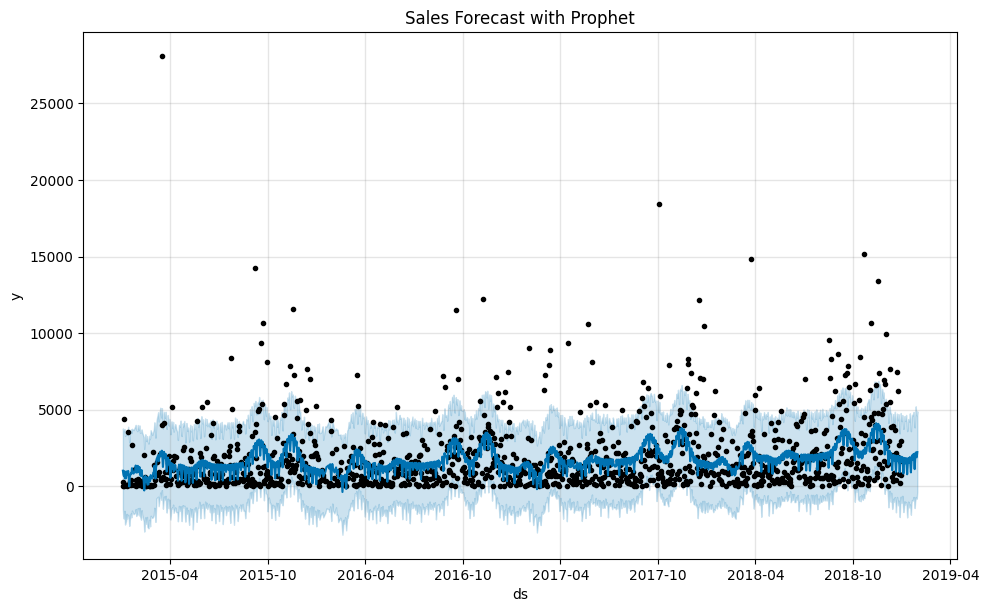

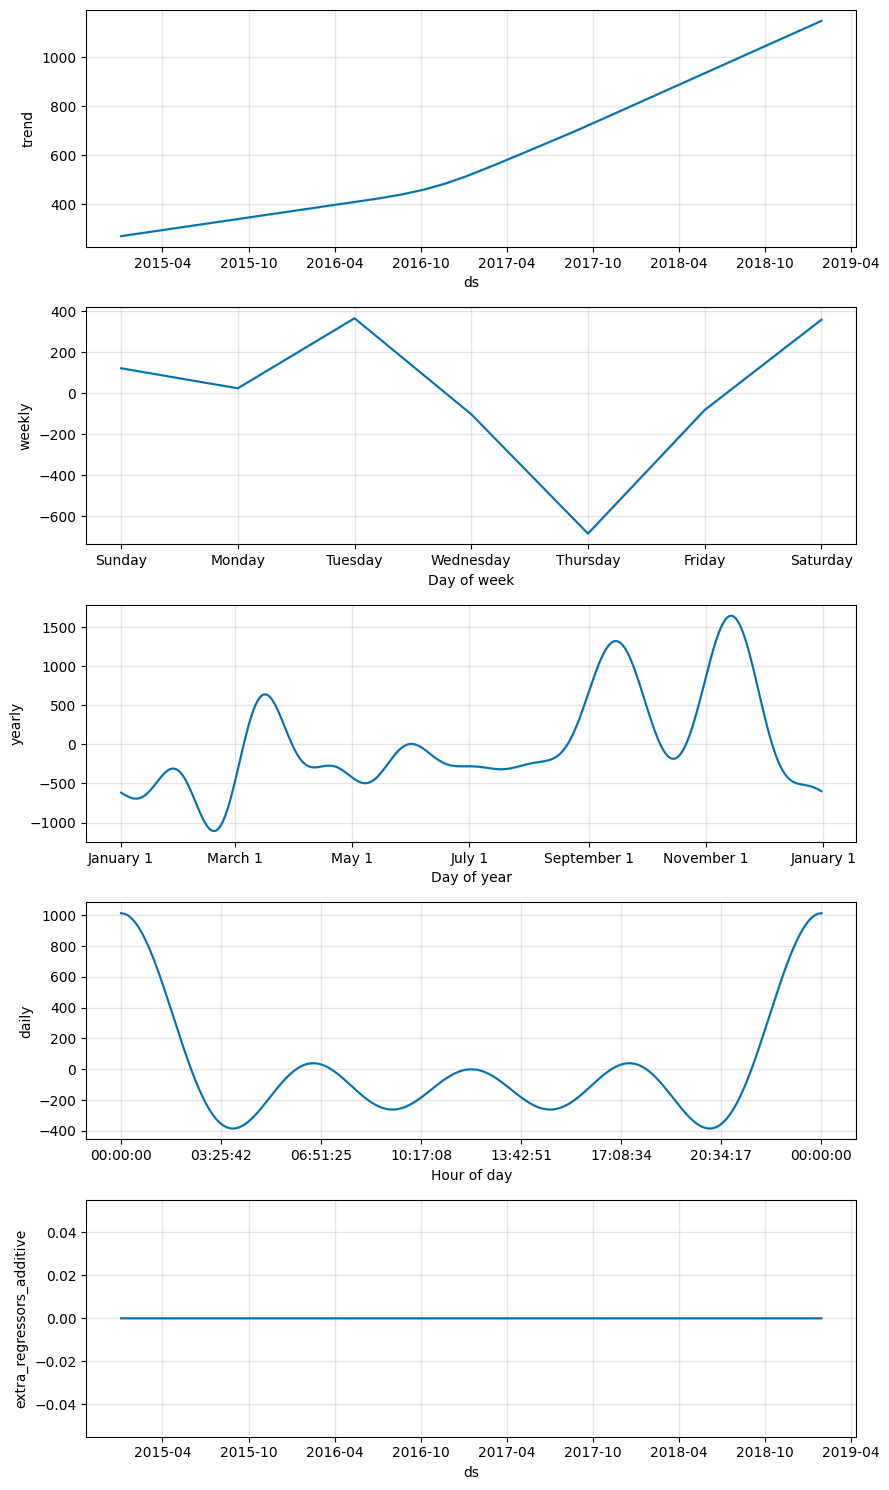


Forecast saved to '/content/drive/My Drive/SuperstoreProject/sales_forecast.csv'


In [ ]:

# Step 4: Train a Time Series Forecasting Model using Prophet

# Import required libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 4.1: Load and Clean the Original Dataset
try:
    full_df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/train.csv')
except FileNotFoundError:
    print("Error: 'train.csv' not found in '/content/drive/My Drive/SuperstoreProject/'.")
    print("Please upload the Superstore dataset from https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting to the folder.")
    raise

# Inspect raw Order Date values
print("Raw Order Date values (first 20 rows):")
print(full_df['Order Date'].head(20))
print("\nUnique Order Date values (sample):")
print(full_df['Order Date'].unique()[:20])
print("\nTotal rows in full_df:", len(full_df))

# Check for non-date entries
full_df['Order Date'] = full_df['Order Date'].astype(str)
invalid_dates = full_df['Order Date'][~full_df['Order Date'].str.match(r'^\d{1,2}/\d{1,2}/\d{4}$', na=False)]
print("\nPotential invalid Order Date entries (not matching DD/MM/YYYY or MM/DD/YYYY):")
print(invalid_dates.head(10))
print(f"Number of invalid dates: {len(invalid_dates)}")

# Step 4.2: Parse Order Date
# Try multiple date formats
full_df['Order Date'] = pd.to_datetime(full_df['Order Date'], format='%d/%m/%Y', errors='coerce')
if full_df['Order Date'].isnull().any():
    print("\nDD/MM/YYYY parsing failed for some dates. Trying MM/DD/YYYY...")
    full_df['Order Date'] = pd.to_datetime(full_df['Order Date'], format='%m/%d/%Y', errors='coerce')
if full_df['Order Date'].isnull().any():
    print("\nSpecific formats failed. Trying mixed format...")
    full_df['Order Date'] = pd.to_datetime(full_df['Order Date'], format='mixed', errors='coerce')

# Check for NaT values
print("\nMissing values in Order Date after parsing:")
print(full_df['Order Date'].isnull().sum())
if full_df['Order Date'].isnull().any():
    print("\nRows with NaT in Order Date:")
    print(full_df[full_df['Order Date'].isnull()][['Order Date', 'Sales']])
    full_df = full_df.dropna(subset=['Order Date'])

# Clean Sales column
full_df = full_df.dropna(subset=['Sales'])
full_df = full_df[full_df['Sales'] > 0]

# Verify cleaned data
print("\nCleaned full_df Preview:")
print(full_df[['Order Date', 'Sales']].head())
print("\nTotal rows after cleaning:", len(full_df))

# Save cleaned full dataset
full_df.to_csv('/content/drive/My Drive/SuperstoreProject/full_cleaned_superstore_data.csv', index=False)

# Step 4.3: Aggregate to Daily Sales
daily_sales = full_df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='%d/%m/%Y', errors='coerce')
daily_sales = daily_sales.dropna(subset=['Order Date'])
daily_sales['IsHoliday'] = daily_sales['Order Date'].apply(lambda x: 1 if x.month == 12 else 0)

# Verify daily_sales
print("\nDaily Sales Data Preview:")
print(daily_sales.head())
print("\nData Info:")
print(daily_sales.info())
print("\nMissing Values:")
print(daily_sales.isnull().sum())
print("\nTotal rows in daily_sales:", len(daily_sales))

# Save daily_sales
daily_sales.to_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv', index=False)

# Step 4.4: Prepare Data for Prophet
prophet_df = daily_sales[['Order Date', 'Sales', 'IsHoliday']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Verify no NaN/NaT in ds or y
print("\nMissing values in prophet_df:")
print(prophet_df[['ds', 'y']].isnull().sum())
if prophet_df['ds'].isnull().any() or prophet_df['y'].isnull().any():
    print("\nRows with NaN/NaT in prophet_df:")
    print(prophet_df[prophet_df['ds'].isnull() | prophet_df['y'].isnull()])
    prophet_df = prophet_df.dropna(subset=['ds', 'y'])

# Check if prophet_df has enough rows
print("\nTotal rows in prophet_df:", len(prophet_df))
if len(prophet_df) < 2:
    print("Error: prophet_df has less than 2 rows. Please check the input data or re-upload train.csv.")
    raise ValueError("Insufficient data for Prophet model.")

# Verify prophet_df
print("\nProphet DataFrame Preview:")
print(prophet_df.head())

# Step 4.5: Train the Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_regressor('IsHoliday')
model.fit(prophet_df)

# Step 4.6: Generate Future Dates
future = model.make_future_dataframe(periods=30)
future['IsHoliday'] = 0  # Default to 0 for future dates
print("\nFuture Dates Preview:")
print(future.tail())

# Step 4.7: Make Predictions
forecast = model.predict(future)
print("\nForecast Preview (last 5 rows):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Step 4.8: Visualize Results
model.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.show()

model.plot_components(forecast)
plt.show()

# Step 4.9: Save the Forecast
forecast.to_csv('/content/drive/My Drive/SuperstoreProject/sales_forecast.csv', index=False)
print("\nForecast saved to '/content/drive/My Drive/SuperstoreProject/sales_forecast.csv'")


In [ ]:
# Step 5.1: Prepare Data for Power BI

import pandas as pd

# Load the cleaned and forecast datasets
full_df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/full_cleaned_superstore_data.csv')
daily_sales = pd.read_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv')
forecast = pd.read_csv('/content/drive/My Drive/SuperstoreProject/sales_forecast.csv')

# Ensure Order Date is datetime
full_df['Order Date'] = pd.to_datetime(full_df['Order Date'], format='%d/%m/%Y', errors='coerce')
daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='%d/%m/%Y', errors='coerce')
forecast['ds'] = pd.to_datetime(forecast['ds'], errors='coerce')

# Create a combined dataset for Power BI (historical + forecast)
# Select relevant forecast columns
forecast_subset = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Order Date', 'yhat': 'Forecasted Sales'})
forecast_subset['Type'] = 'Forecast'

# Historical daily sales
daily_sales_subset = daily_sales[['Order Date', 'Sales']].rename(columns={'Sales': 'Forecasted Sales'})
daily_sales_subset['Type'] = 'Historical'

# Combine historical and forecast data
combined_df = pd.concat([daily_sales_subset, forecast_subset], ignore_index=True)

# Add confidence intervals for forecast rows
combined_df['Lower Bound'] = combined_df['yhat_lower'].fillna(0)
combined_df['Upper Bound'] = combined_df['yhat_upper'].fillna(0)

# Save the combined dataset
combined_df.to_csv('/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv', index=False)

# Preview the combined dataset
print("Combined Dataset Preview:")
print(combined_df.head())
print("\nCombined Dataset Info:")
print(combined_df.info())
print("\nMissing Values in Combined Dataset:")
print(combined_df.isnull().sum())

Combined Dataset Preview:
  Order Date  Forecasted Sales        Type  yhat_lower  yhat_upper  \
0        NaT            16.448  Historical         NaN         NaN   
1        NaT           288.060  Historical         NaN         NaN   
2        NaT            19.536  Historical         NaN         NaN   
3        NaT          4407.100  Historical         NaN         NaN   
4        NaT            87.158  Historical         NaN         NaN   

   Lower Bound  Upper Bound  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order Date        1260 non-null   datetime64[ns]
 1   Forecasted Sales  2490 non-null   float64       
 2   Type              2490

In [ ]:

# Step 5.1: Prepare Data for Power BI

import pandas as pd

# Step 5.1.1: Load and Inspect Input Datasets
try:
    daily_sales = pd.read_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv')
    forecast = pd.read_csv('/content/drive/My Drive/SuperstoreProject/sales_forecast.csv')
except FileNotFoundError as e:
    print(f"Error: File not found - {e}. Please ensure 'engineered_daily_sales.csv' and 'sales_forecast.csv' are in '/content/drive/My Drive/SuperstoreProject/'.")
    raise

# Inspect daily_sales
print("Daily Sales Preview:")
print(daily_sales.head())
print("\nDaily Sales Info:")
print(daily_sales.info())
print("\nDaily Sales Order Date Missing Values:")
print(daily_sales['Order Date'].isnull().sum())
print("\nDaily Sales Order Date Sample (first 20):")
print(daily_sales['Order Date'].head(20))

# Inspect forecast
print("\nForecast Preview:")
print(forecast.head())
print("\nForecast Info:")
print(forecast.info())
print("\nForecast ds Missing Values:")
print(forecast['ds'].isnull().sum())
print("\nForecast ds Sample (first 20):")
print(forecast['ds'].head(20))

# Step 5.1.2: Parse Dates
# Ensure Order Date in daily_sales is datetime
daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='%d/%m/%Y', errors='coerce')
if daily_sales['Order Date'].isnull().any():
    print("\nTrying MM/DD/YYYY for daily_sales Order Date...")
    daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='%m/%d/%Y', errors='coerce')
if daily_sales['Order Date'].isnull().any():
    print("\nTrying mixed format for daily_sales Order Date...")
    daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='mixed', errors='coerce')

# Drop rows with NaT in daily_sales
if daily_sales['Order Date'].isnull().any():
    print("\nRows with NaT in daily_sales Order Date:")
    print(daily_sales[daily_sales['Order Date'].isnull()][['Order Date', 'Sales', 'IsHoliday']])
    daily_sales = daily_sales.dropna(subset=['Order Date'])

# Ensure ds in forecast is datetime
forecast['ds'] = pd.to_datetime(forecast['ds'], format='%Y-%m-%d', errors='coerce')
if forecast['ds'].isnull().any():
    print("\nRows with NaT in forecast ds:")
    print(forecast[forecast['ds'].isnull()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    forecast = forecast.dropna(subset=['ds'])

# Verify data after parsing
print("\nDaily Sales Order Date Missing Values After Parsing:")
print(daily_sales['Order Date'].isnull().sum())
print("\nForecast ds Missing Values After Parsing:")
print(forecast['ds'].isnull().sum())
print("\nTotal rows in daily_sales:", len(daily_sales))
print("\nTotal rows in forecast:", len(forecast))

# Step 5.1.3: Create Combined Dataset
# Historical daily sales
daily_sales_subset = daily_sales[['Order Date', 'Sales']].rename(columns={'Sales': 'Forecasted Sales'})
daily_sales_subset['Type'] = 'Historical'

# Forecasted sales
forecast_subset = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Order Date', 'yhat': 'Forecasted Sales'})
forecast_subset['Type'] = 'Forecast'

# Combine datasets
combined_df = pd.concat([daily_sales_subset, forecast_subset], ignore_index=True)

# Add confidence intervals (fill NaN with 0 for historical rows)
combined_df['Lower Bound'] = combined_df['yhat_lower'].fillna(0)
combined_df['Upper Bound'] = combined_df['yhat_upper'].fillna(0)

# Verify combined dataset
print("\nCombined Dataset Preview:")
print(combined_df.head())
print("\nCombined Dataset Info:")
print(combined_df.info())
print("\nCombined Dataset Missing Values:")
print(combined_df.isnull().sum())
print("\nCombined Dataset Order Date Sample (first 20):")
print(combined_df['Order Date'].head(20))
print("\nTotal rows in combined_df:", len(combined_df))

# Step 5.1.4: Save Combined Dataset
if combined_df['Order Date'].isnull().any():
    print("\nError: Order Date contains NaT values. Please check input datasets.")
    raise ValueError("Cannot save combined dataset with missing Order Date values.")
combined_df.to_csv('/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv', index=False)
print("\nCombined dataset saved to '/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv'")


Daily Sales Preview:
   Order Date     Sales  IsHoliday
0  2015-01-03    16.448          0
1  2015-01-04   288.060          0
2  2015-01-05    19.536          0
3  2015-01-06  4407.100          0
4  2015-01-07    87.158          0

Daily Sales Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  1230 non-null   object 
 1   Sales       1230 non-null   float64
 2   IsHoliday   1230 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.0+ KB
None

Daily Sales Order Date Missing Values:
0

Daily Sales Order Date Sample (first 20):
0     2015-01-03
1     2015-01-04
2     2015-01-05
3     2015-01-06
4     2015-01-07
5     2015-01-09
6     2015-01-10
7     2015-01-11
8     2015-01-13
9     2015-01-14
10    2015-01-15
11    2015-01-16
12    2015-01-18
13    2015-01-19
14    2015-01-20
15    2015-01-23
16    2015-01-

In [ ]:
import pandas as pd

# Load the datasets
daily_sales = pd.read_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv')
forecast = pd.read_csv('/content/drive/My Drive/SuperstoreProject/sales_forecast.csv')

# Parse dates with robust error handling
daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], errors='coerce')
if daily_sales['Order Date'].isnull().all():
    print("Warning: All Order Date values are NaT. Trying mixed format...")
    daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'], format='mixed', errors='coerce')
daily_sales = daily_sales.dropna(subset=['Order Date', 'Sales'])

forecast['ds'] = pd.to_datetime(forecast['ds'], errors='coerce')
forecast = forecast.dropna(subset=['ds', 'yhat'])

# Create subsets with explicit Type assignment
daily_sales_subset = daily_sales[['Order Date', 'Sales']].rename(columns={'Sales': 'Forecasted Sales'})
daily_sales_subset['Type'] = 'Historical'

forecast_subset = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Order Date', 'yhat': 'Forecasted Sales'})
forecast_subset['Type'] = 'Forecast'  # Ensure this line is correct

# Combine datasets and verify Type
combined_df = pd.concat([daily_sales_subset, forecast_subset], ignore_index=True, join='outer')
combined_df['Lower Bound'] = combined_df['yhat_lower'].fillna(0)
combined_df['Upper Bound'] = combined_df['yhat_upper'].fillna(0)

# Drop rows where Forecasted Sales is NaN (if any)
combined_df = combined_df.dropna(subset=['Forecasted Sales'])

# Verify before saving
print("\nCombined Data Preview:")
print(combined_df.head())
print("\nCombined Data Info:")
print(combined_df.info())
print("\nCombined Data Row Count:", len(combined_df))
print("\nCombined Data Type Value Counts:")
print(combined_df['Type'].value_counts())

# Save the updated file
combined_df.to_csv('/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv', index=False)
print("\nCombined dataset updated and saved to '/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv'")


Combined Data Preview:
  Order Date  Forecasted Sales        Type  yhat_lower  yhat_upper  \
0 2015-01-03            16.448  Historical         NaN         NaN   
1 2015-01-04           288.060  Historical         NaN         NaN   
2 2015-01-05            19.536  Historical         NaN         NaN   
3 2015-01-06          4407.100  Historical         NaN         NaN   
4 2015-01-07            87.158  Historical         NaN         NaN   

   Lower Bound  Upper Bound  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  

Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order Date        2490 non-null   datetime64[ns]
 1   Forecasted Sales  2490 non-null   float64       
 2   Type              2490 non-

In [ ]:
import pandas as pd

# Load the datasets
daily_sales = pd.read_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv')
forecast = pd.read_csv('/content/drive/My Drive/SuperstoreProject/sales_forecast.csv')
combined_df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv')

# Inspect daily_sales
print("Daily Sales Preview:")
print(daily_sales.head())
print("\nDaily Sales Info:")
print(daily_sales.info())
print("\nDaily Sales Row Count:", len(daily_sales))
print("\nDaily Sales Order Date Missing Values:", daily_sales['Order Date'].isnull().sum())

# Inspect forecast
print("\nForecast Preview:")
print(forecast.head())
print("\nForecast Info:")
print(forecast.info())
print("\nForecast Row Count:", len(forecast))
print("\nForecast ds Missing Values:", forecast['ds'].isnull().sum())

# Inspect combined_df
print("\nCombined Data Preview:")
print(combined_df.head())
print("\nCombined Data Info:")
print(combined_df.info())
print("\nCombined Data Row Count:", len(combined_df))
print("\nCombined Data Type Value Counts:")
print(combined_df['Type'].value_counts())

Daily Sales Preview:
   Order Date     Sales  IsHoliday
0  2015-01-03    16.448          0
1  2015-01-04   288.060          0
2  2015-01-05    19.536          0
3  2015-01-06  4407.100          0
4  2015-01-07    87.158          0

Daily Sales Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  1230 non-null   object 
 1   Sales       1230 non-null   float64
 2   IsHoliday   1230 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.0+ KB
None

Daily Sales Row Count: 1230

Daily Sales Order Date Missing Values: 0

Forecast Preview:
           ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2015-01-03  269.946738 -1511.775700  3766.108054   269.946738   269.946738   
1  2015-01-04  270.227680 -2082.205862  3611.223800   270.227680   270.227680   
2  2015-01-05  270.508621 -2137.259710

In [ ]:
import pandas as pd

# Load the datasets
daily_sales = pd.read_csv('/content/drive/My Drive/SuperstoreProject/engineered_daily_sales.csv')
forecast = pd.read_csv('/content/drive/My Drive/SuperstoreProject/sales_forecast.csv')
combined_df = pd.read_csv('/content/drive/My Drive/SuperstoreProject/combined_sales_forecast.csv')

# Inspect daily_sales
print("Daily Sales Preview:")
print(daily_sales.head())
print("\nDaily Sales Info:")
print(daily_sales.info())
print("\nDaily Sales Row Count:", len(daily_sales))
print("\nDaily Sales Order Date Missing Values:", daily_sales['Order Date'].isnull().sum())

# Inspect forecast
print("\nForecast Preview:")
print(forecast.head())
print("\nForecast Info:")
print(forecast.info())
print("\nForecast Row Count:", len(forecast))
print("\nForecast ds Missing Values:", forecast['ds'].isnull().sum())

# Inspect intermediate subsets (re-run the combination logic here)
daily_sales_subset = daily_sales[['Order Date', 'Sales']].rename(columns={'Sales': 'Forecasted Sales'})
daily_sales_subset['Type'] = 'Historical'

forecast_subset = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Order Date', 'yhat': 'Forecasted Sales'})
forecast_subset['Type'] = 'Forecast'

print("\nDaily Sales Subset Preview:")
print(daily_sales_subset.head())
print("\nDaily Sales Subset Info:")
print(daily_sales_subset.info())
print("\nDaily Sales Subset Row Count:", len(daily_sales_subset))
print("\nDaily Sales Subset Type Value Counts:")
print(daily_sales_subset['Type'].value_counts())

print("\nForecast Subset Preview:")
print(forecast_subset.head())
print("\nForecast Subset Info:")
print(forecast_subset.info())
print("\nForecast Subset Row Count:", len(forecast_subset))
print("\nForecast Subset Type Value Counts:")
print(forecast_subset['Type'].value_counts())

# Inspect combined_df
print("\nCombined Data Preview:")
print(combined_df.head())
print("\nCombined Data Info:")
print(combined_df.info())
print("\nCombined Data Row Count:", len(combined_df))
print("\nCombined Data Type Value Counts:")
print(combined_df['Type'].value_counts())

Daily Sales Preview:
   Order Date     Sales  IsHoliday
0  2015-01-03    16.448          0
1  2015-01-04   288.060          0
2  2015-01-05    19.536          0
3  2015-01-06  4407.100          0
4  2015-01-07    87.158          0

Daily Sales Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  1230 non-null   object 
 1   Sales       1230 non-null   float64
 2   IsHoliday   1230 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.0+ KB
None

Daily Sales Row Count: 1230

Daily Sales Order Date Missing Values: 0

Forecast Preview:
           ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2015-01-03  269.946738 -1511.775700  3766.108054   269.946738   269.946738   
1  2015-01-04  270.227680 -2082.205862  3611.223800   270.227680   270.227680   
2  2015-01-05  270.508621 -2137.259710